### Library Imports and Seed Setting

#### Imports Libraries

In [78]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import imutils

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten,
    BatchNormalization, Dropout, GlobalAveragePooling2D, Dense
)
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator, img_to_array, array_to_img, load_img
)

# Keras Utilities

# Scikit-learn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

#### Setting Seed

In [48]:
# Global variables
SAVE = False
SEED = 42

# Setting seed for consistent results
tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Data Visualization updates
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams.update({'font.size': 14})

# Data Classifications
CLASS_TYPES = ['pituitary', 'notumor', 'meningioma', 'glioma']
N_TYPES = len(CLASS_TYPES)

### Preprocessing and Visualization

#### Train and Test Paths

In [79]:
USER_PATH = "data"
CROPPED_PATH = "data_cropped"
TRAIN_DIR = os.path.join(USER_PATH, "Training")
TEST_DIR = os.path.join(USER_PATH, "Testing")
CROPPED_TRAIN = os.path.join(CROPPED_PATH, "Training")
CROPPED_TEST = os.path.join(CROPPED_PATH, "Testing")
image_size = (150, 150)

#### Helper functions to show crop vs uncropped, data labels, data path

In [80]:
# Crop function
def crop_imgs_from_dir(input_dir, output_dir, target_size=image_size, add_pixels_value=0):
    for class_name in os.listdir(input_dir):
        class_dir = os.path.join(input_dir, class_name)
        if not os.path.isdir(class_dir):
            continue  # Skip non-directories like .DS_Store

        save_dir = os.path.join(output_dir, class_name)
        os.makedirs(save_dir, exist_ok=True)

        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue  # Skip non-image files

            img = cv2.imread(img_path)
            if img is None:
                continue

            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            gray = cv2.GaussianBlur(gray, (5, 5), 0)
            thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
            thresh = cv2.erode(thresh, None, iterations=2)
            thresh = cv2.dilate(thresh, None, iterations=2)

            cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cnts = imutils.grab_contours(cnts)

            if cnts:
                c = max(cnts, key=cv2.contourArea)
                extLeft = tuple(c[c[:, :, 0].argmin()][0])
                extRight = tuple(c[c[:, :, 0].argmax()][0])
                extTop = tuple(c[c[:, :, 1].argmin()][0])
                extBot = tuple(c[c[:, :, 1].argmax()][0])

                new_img = img[max(extTop[1] - add_pixels_value, 0): min(extBot[1] + add_pixels_value, img.shape[0]),
                              max(extLeft[0] - add_pixels_value, 0): min(extRight[0] + add_pixels_value, img.shape[1])]
            else:
                new_img = img

            resized = cv2.resize(new_img, target_size)
            cv2.imwrite(os.path.join(save_dir, img_name), resized)


# Crop images first
crop_imgs_from_dir(TRAIN_DIR, CROPPED_TRAIN)
crop_imgs_from_dir(TEST_DIR, CROPPED_TEST)

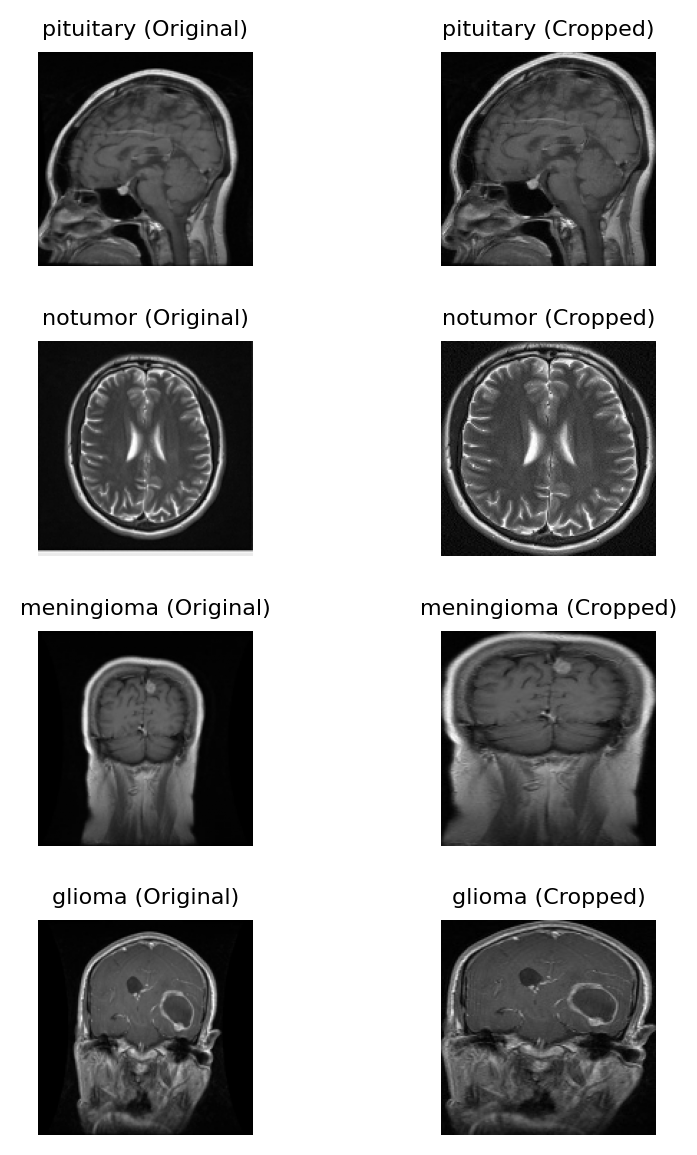

In [83]:
def show_uncropped_vs_cropped(uncropped_dir, cropped_dir, class_names, img_size=(150, 150)):
    fig, axes = plt.subplots(len(class_names), 2, figsize=(5, 6))

    for i, class_name in enumerate(class_names):
        # Get list of images
        uncropped_imgs = os.listdir(os.path.join(uncropped_dir, class_name))
        cropped_imgs = os.listdir(os.path.join(cropped_dir, class_name))

        # Pick a random image name that exists in both
        candidates = list(set(uncropped_imgs).intersection(set(cropped_imgs)))
        if not candidates:
            print(f"No common images found in class: {class_name}")
            continue

        img_name = random.choice(candidates)

        # Load images
        uncropped_path = os.path.join(uncropped_dir, class_name, img_name)
        cropped_path = os.path.join(cropped_dir, class_name, img_name)

        uncropped_img = Image.open(uncropped_path).convert("L").resize(img_size)
        cropped_img = Image.open(cropped_path).convert("L").resize(img_size)

        # Plotting
        axes[i, 0].imshow(uncropped_img, cmap='gray')
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f"{class_name} (Original)", fontsize=8)

        axes[i, 1].imshow(cropped_img, cmap='gray')
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f"{class_name} (Cropped)", fontsize=8)
       

    plt.tight_layout()
    plt.show()

# Run it
show_uncropped_vs_cropped(
    uncropped_dir=os.path.join(USER_PATH, "Training"),
    cropped_dir=os.path.join(CROPPED_PATH, "Training"),
    class_names=CLASS_TYPES,
    img_size=image_size 
)

In [82]:
# Function for importing image paths and labels from directory
def get_data_labels(directory, shuffle=True, random_state=0):
    """
    Traverse a directory containing subfolders (one per class),
    collect full image paths and corresponding labels.
    """
    from sklearn.utils import shuffle
    import os

    data_path = []
    data_labels = []
    
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)

        if not os.path.isdir(label_dir):
            continue  # Skip non-folder entries

        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            data_path.append(image_path)
            data_labels.append(label)
            
    if shuffle:
        data_path, data_labels = shuffle(data_path, data_labels, random_state=random_state)
            
    return data_path, data_labels


In [51]:
# Setting up file paths for training and testing
USER_PATH = r"data_cropped"
train_dir = USER_PATH + r'/Training/'
test_dir = USER_PATH + r'/Testing/'

# Getting data using above function
train_paths, train_labels = get_data_labels(train_dir)
test_paths, test_labels = get_data_labels(test_dir)

# Create dataframe from paths
df = pd.DataFrame({
    'filename': train_paths,
    'class': train_labels
})

# Printing traing and testing sample sizes
print('Training')
print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_labels)}')
print('\nTesting')
print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_labels)}')

Training
Number of Paths: 5712
Number of Labels: 5712

Testing
Number of Paths: 1311
Number of Labels: 1311


#### Pie Charts to visualize data distribution

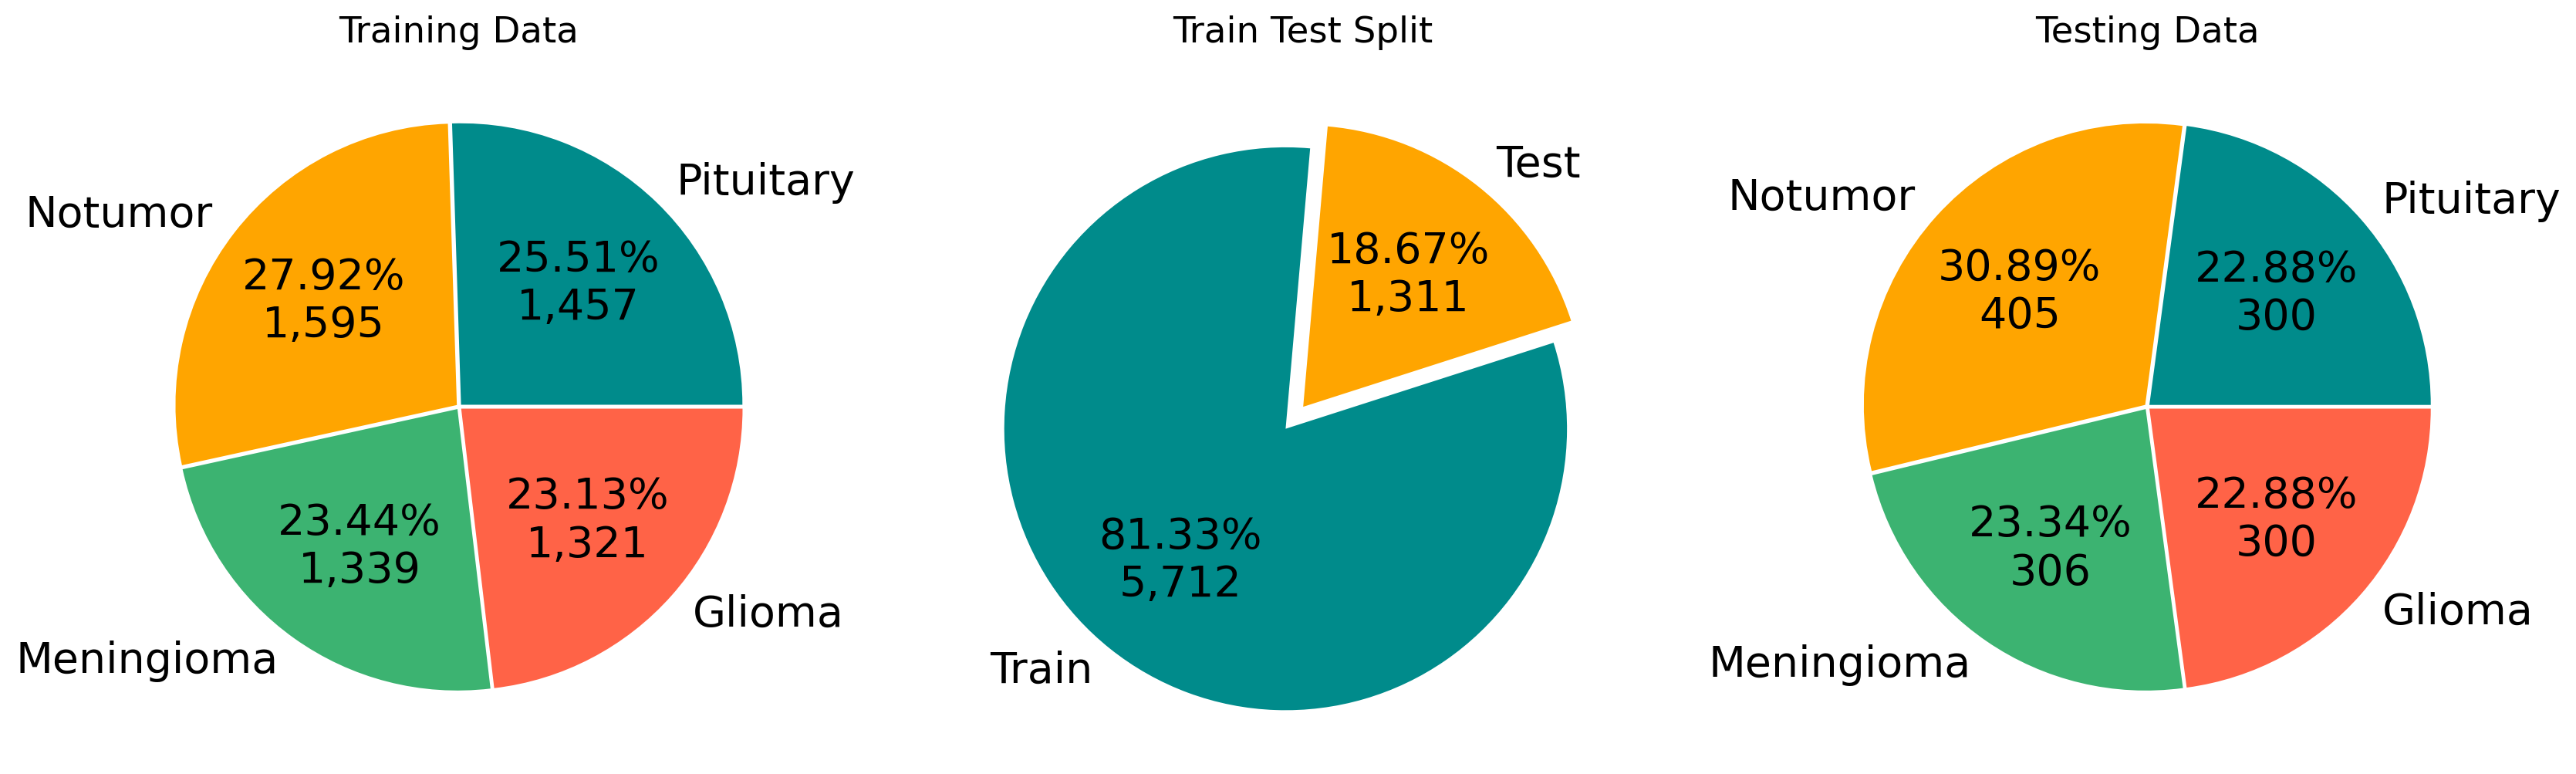

In [71]:
_, ax = plt.subplots(ncols=3, figsize=(20, 14))

# Plotting training data types
class_counts = [len([x for x in train_labels if x == label]) for label in CLASS_TYPES]
ax[0].set_title('Training Data')
ax[0].pie(
    class_counts,
    labels=[label.title() for label in CLASS_TYPES],
    colors = ['darkcyan', 'orange', 'mediumseagreen', 'tomato'], 
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts) / 100),
    explode=tuple(0.01 for i in range(N_TYPES)),
    textprops={'fontsize': 20}
)

# Plotting distribution of train test split
ax[1].set_title('Train Test Split')
ax[1].pie(
    [len(train_labels), len(test_labels)],
    labels=['Train','Test'],
    colors=['darkcyan', 'orange'], 
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum([len(train_labels), len(test_labels)]) / 100),
    explode=(0.1, 0),
    startangle=85,
    textprops={'fontsize': 20}
)

# Plotting testing data types
class_counts = [len([x for x in test_labels if x == label]) for label in CLASS_TYPES]
ax[2].set_title('Testing Data')
ax[2].pie(
    class_counts,
    labels=[label.title() for label in CLASS_TYPES],
    colors = ['darkcyan', 'orange', 'mediumseagreen', 'tomato'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts) / 100),
    explode=tuple(0.01 for i in range(N_TYPES)), 
    textprops={'fontsize': 20}  # Set the font size for the text on the pie chart
)

plt.show()

#### Train, Test and Validation Data Generator

In [52]:
# # Data augmentation and preprocessing for training
batch_size = 32
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    brightness_range=(0.85, 1.15),
    width_shift_range=0.002,
    height_shift_range=0.002,
    shear_range=12.5,
    zoom_range=0,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode="nearest"
)

# Test generator (no augmentation, only rescaling)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['class'],  # maintain class distribution
    random_state=SEED
)


Found 1311 images belonging to 4 classes.


#### Augmented vs Original Image generator helper function

In [47]:
def show_augmented_vs_original(train_paths, image_size=image_size, num_samples=5, row_height=2):
    """
    Display side-by-side comparison of original and augmented MRI images.
    """
    fig, axes = plt.subplots(num_samples, 2, figsize=(5, row_height * num_samples))

    for i in range(num_samples):
        # Load and prepare original image
        original_img = load_img(train_paths[i], target_size=image_size)
        original_arr = img_to_array(original_img)
        raw_input = np.expand_dims(original_arr, axis=0)

        # Generate augmented version
        aug_iterator = train_datagen.flow(raw_input, batch_size=1)
        augmented_arr = next(aug_iterator)[0]

        # Normalize original for consistent comparison
        original_arr = original_arr / 255.0

        # If grayscale, convert accordingly
        if original_arr.shape[-1] == 1:
            cmap = 'gray'
            original_arr = original_arr.squeeze()
            augmented_arr = augmented_arr.squeeze()
        else:
            cmap = None

        # Plot original
        axes[i, 0].imshow(original_arr, cmap=cmap)
        axes[i, 0].axis('off')
        axes[i, 0].set_title("Original")

        # Plot augmented
        axes[i, 1].imshow(augmented_arr, cmap=cmap)
        axes[i, 1].axis('off')
        axes[i, 1].set_title("Augmented")

    plt.tight_layout()
    plt.show()


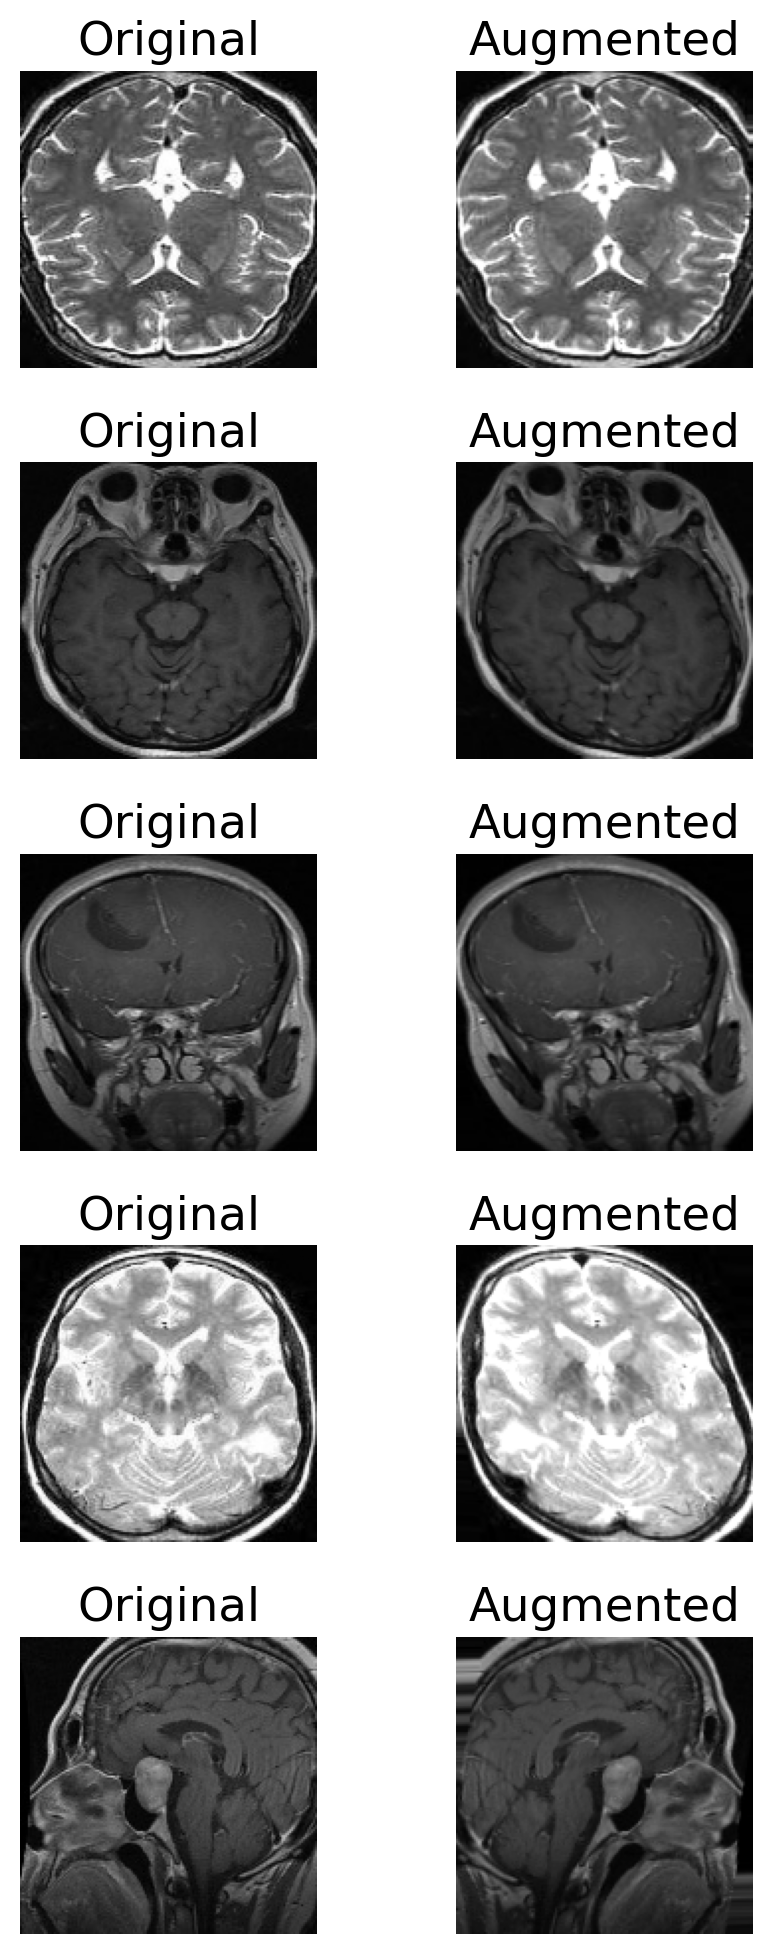

In [48]:
show_augmented_vs_original(train_paths=train_paths[:5])

#### Function to plot sample prediction, confusion matrix and accuracy scores

In [10]:
# Output Images and Labels Visualization #
def plot_sample_predictions(model, test_generator, categories, test_dir, num_samples=9, figsize=(12, 8)):
    
    # Make predictions on the test dataset
    predictions = model.predict(test_generator)
    predicted_categories = np.argmax(predictions, axis=1)
    true_categories = test_generator.classes

    # Randomly sample test images
    test_images = np.array(test_generator.filepaths)
    sample_indices = np.random.choice(len(test_images), size=num_samples, replace=False)
    sample_images = test_images[sample_indices]
    sample_predictions = [categories[predicted_categories[i]] for i in sample_indices]
    sample_true_labels = [categories[true_categories[i]] for i in sample_indices]

    # Plot sample images with their predicted and true labels
    plt.figure(figsize=figsize)
    
    # Loop over samples
    for i, image_path in enumerate(sample_images):
        # Form subplot and plot
        plt.subplot(3, 3, i + 1)
        img = plt.imread(image_path)
        plt.imshow(img, cmap='gray')
        plt.axis("off")
        
        # Set axis label color depending on correct prediction or not
        prediction_color = 'green' if sample_predictions[i] == sample_true_labels[i] else 'red'
        plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color=prediction_color)
        
    plt.tight_layout()
    plt.show()

### Model Training and Evaluation

#### CNN Architecture

In [35]:
epochs = 100
image_shape = (150, 150, 3)

# Data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

val_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='class',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Define model architecture
model = Sequential([
    Input(shape=image_shape),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(128, (4, 4), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    Flatten(),
    Dense(384, activation='relu'),
    Dropout(0.3),
    Dense(N_TYPES, activation='softmax')
])

model.compile(
    optimizer=Adamax(learning_rate=0.0009534),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
model_es = EarlyStopping(
    monitor='val_loss',
    min_delta=1e-4,
    patience=8,
    verbose=True,
    restore_best_weights=True
)
model_rlr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=5,
    min_lr=1e-6,
    verbose=True
)

Found 4569 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.


#### Visualizing the CNN layers

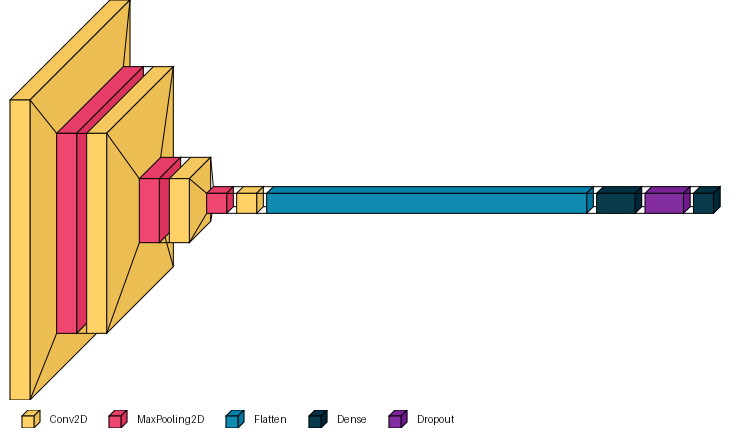

In [78]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from visualkeras import layered_view

# Visualize the model without warnings%
layered_view(model, legend=True, max_xy=300)

#### Fitting the model

In [36]:
# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=[model_es, model_rlr]
)

/opt/anaconda3/envs/adv-data-proj/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 31s 198ms/step - accuracy: 0.3944 - loss: 1.2193 - val_accuracy: 0.6205 - val_loss: 0.9505 - learning_rate: 9.5340e-04
Epoch 2/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 194ms/step - accuracy: 0.6968 - loss: 0.7554 - val_accuracy: 0.7241 - val_loss: 0.7031 - learning_rate: 9.5340e-04
Epoch 3/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 194ms/step - accuracy: 0.7636 - loss: 0.6015 - val_accuracy: 0.6777 - val_loss: 0.8864 - learning_rate: 9.5340e-04
Epoch 4/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 30s 211ms/step - accuracy: 0.7849 - loss: 0.5554 - val_accuracy: 0.8223 - val_loss: 0.4949 - learning_rate: 9.5340e-04
Epoch 5/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 186ms/step - accuracy: 0.8356 - loss: 0.4377 - val_accuracy: 0.7768 - val_loss: 0.6441 - learning_rate: 9.5340e-04
Epoch 6/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 30s 208ms/step - accuracy: 0.8594 - loss: 0.3894 - val_accuracy: 0.8464 - val_loss: 0.4572 - learning_rate: 9.5340e-04
Epoch 7/100
143/143 ━━━━━━━━━━━━━━━━━━━━

#### Evaluating for loss and accuracy on test set

In [37]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:0.5f}")
print(f"Test Accuracy: {test_acc:0.5f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.9503 - loss: 0.1687 
Test Loss: 0.11505
Test Accuracy: 0.96949


#### Plot accuracy and loss graphs

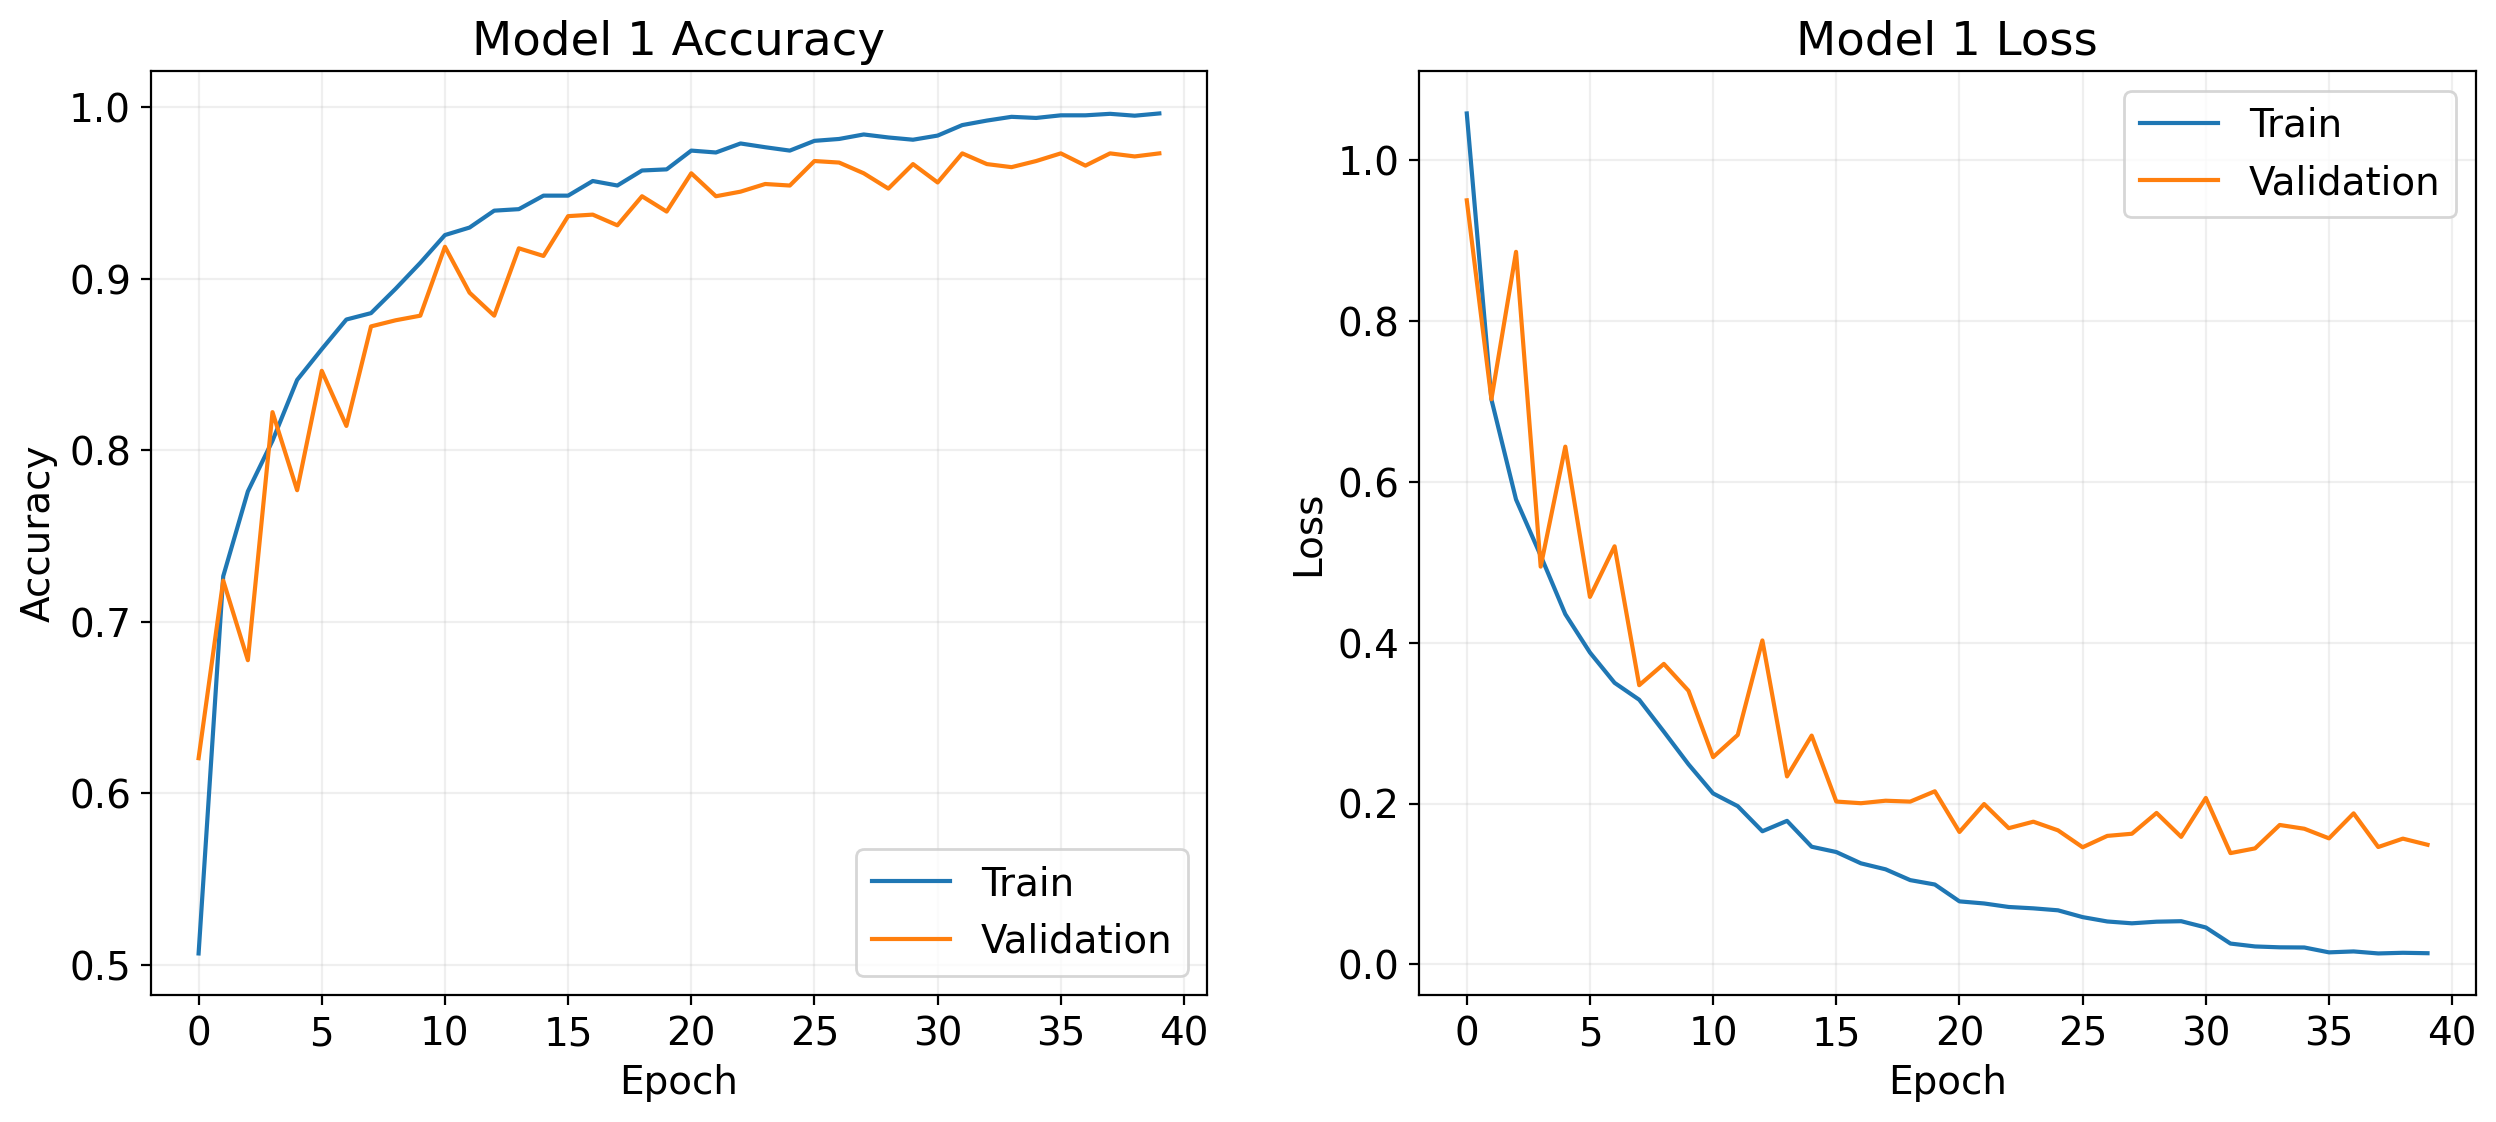

In [38]:
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plot the training and validation accuracy over epochs
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model 1 Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.2)

# Plot the training and validation loss over epochs
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model 1 Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha=0.2)

plt.show()

#### Save the initial model

In [84]:
model.save('brain_tumor_initial_cnn.keras')

#### Hyperparameter Optimization

In [53]:
# Custom K-Fold tuner for CNN using Keras Tuner
import keras_tuner as kt
from sklearn.model_selection import StratifiedKFold

# K-Fold setup
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Define the model search space
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(150, 150, 3)))

    model.add(Conv2D(
        filters=hp.Choice('conv1_filters', [32, 64]),
        kernel_size=hp.Choice('conv1_kernel', [3, 4]),
        padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))

    model.add(Conv2D(
        filters=hp.Choice('conv2_filters', [64, 128]),
        kernel_size=hp.Choice('conv2_kernel', [3, 4]),
        padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))

    model.add(Conv2D(
        filters=hp.Choice('conv3_filters', [128]),
        kernel_size=hp.Choice('conv3_kernel', [3, 4]),
        padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))

    model.add(Conv2D(
        filters=128,
        kernel_size=hp.Choice('conv4_kernel', [3, 4]),
        padding='same', activation='relu'))

    model.add(Flatten())
    model.add(Dense(
        units=hp.Int('dense_units', 256, 512, step=64), activation='relu'))
    model.add(Dropout(hp.Float('dropout_rate', 0.3, 0.6, step=0.1)))
    model.add(Dense(N_TYPES, activation='softmax'))

    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    model.compile(
        optimizer=Adamax(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

# Augmented ImageDataGenerator for training
def get_train_aug():
    return ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        brightness_range=(0.85, 1.15),
        width_shift_range=0.002,
        height_shift_range=0.002,
        shear_range=12.5,
        zoom_range=0,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode="nearest"
    )

# Custom Tuner class using K-Fold
class CVTuner(kt.RandomSearch):
    def run_trial(self, trial, df, batch_size=32, image_size=(150, 150), epochs=50):
        acc_per_fold = []

        for fold, (train_idx, val_idx) in enumerate(skf.split(df['filename'], df['class'])):
            train_df = df.iloc[train_idx]
            val_df = df.iloc[val_idx]

            train_gen = get_train_aug().flow_from_dataframe(
                train_df, x_col='filename', y_col='class',
                target_size=image_size, batch_size=batch_size,
                class_mode='categorical', shuffle=True)

            val_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
                val_df, x_col='filename', y_col='class',
                target_size=image_size, batch_size=batch_size,
                class_mode='categorical', shuffle=False)

            model = self.hypermodel.build(trial.hyperparameters)

            model_es = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=8, verbose=True, restore_best_weights=True)
            model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-6, verbose=True)

            # Steps per epoch
            steps_per_epoch = (train_gen.samples * 2) // batch_size  # or even ×3
            
            # Validation steps
            validation_steps = val_gen.samples // batch_size
           
            model.fit(
                train_gen,
                steps_per_epoch = steps_per_epoch,
                validation_steps=validation_steps,
                validation_data=val_gen,
                epochs=epochs,
                callbacks=[model_es, model_rlr],
                verbose=1
            )

            loss, acc = model.evaluate(val_gen, verbose=0)
            acc_per_fold.append(acc)

        mean_acc = np.mean(acc_per_fold)
        self.oracle.update_trial(trial.trial_id, {'val_accuracy': mean_acc})

# Run tuner
tuner = CVTuner(
    hypermodel=build_model,
    objective='val_accuracy',
    max_trials=4,
    directory='cnn_tuning_kfold',
    project_name='cnn_kfold_tune'
)

tuner.search(df=df, batch_size=32, epochs=50)


Trial 4 Complete [00h 48m 30s]
val_accuracy: 0.9632346749305725

Best val_accuracy So Far: 0.9695392489433289
Total elapsed time: 06h 12m 40s


In [54]:
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best hyperparameters found:")
for param, value in best_hp.values.items():
    print(f"{param}: {value}")

Best hyperparameters found:
conv1_filters: 32
conv1_kernel: 4
conv2_filters: 128
conv2_kernel: 3
conv3_filters: 128
conv3_kernel: 4
conv4_kernel: 4
dense_units: 256
dropout_rate: 0.5
learning_rate: 0.005862125721808125


#### Rebuild model on entire training dataset

In [55]:
# Rebuild model using the best hyperparameters
best_model = build_model(best_hp)

# Train on full data
full_train_gen = get_train_aug().flow_from_dataframe(
    df, x_col='filename', y_col='class',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Fit model on the full training set
history = best_model.fit(
    full_train_gen,
    epochs=epochs,
    callbacks=[model_es, model_rlr],  # reuse if defined
    verbose=1
)


Found 5712 validated image filenames belonging to 4 classes.


/opt/anaconda3/envs/adv-data-proj/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 29s 159ms/step - accuracy: 0.3695 - loss: 1.3996 - learning_rate: 0.0059
Epoch 2/100


/opt/anaconda3/envs/adv-data-proj/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/opt/anaconda3/envs/adv-data-proj/lib/python3.12/site-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


179/179 ━━━━━━━━━━━━━━━━━━━━ 29s 160ms/step - accuracy: 0.6187 - loss: 0.8612 - learning_rate: 0.0059
Epoch 3/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 29s 160ms/step - accuracy: 0.7361 - loss: 0.6698 - learning_rate: 0.0059
Epoch 4/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 29s 160ms/step - accuracy: 0.7850 - loss: 0.5602 - learning_rate: 0.0059
Epoch 5/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 29s 160ms/step - accuracy: 0.8225 - loss: 0.4579 - learning_rate: 0.0059
Epoch 6/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 29s 161ms/step - accuracy: 0.8543 - loss: 0.3976 - learning_rate: 0.0059
Epoch 7/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 29s 161ms/step - accuracy: 0.8796 - loss: 0.3397 - learning_rate: 0.0059
Epoch 8/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 29s 161ms/step - accuracy: 0.8959 - loss: 0.2812 - learning_rate: 0.0059
Epoch 9/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 29s 161ms/step - accuracy: 0.9024 - loss: 0.2659 - learning_rate: 0.0059
Epoch 10/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 29s 161ms/step - accuracy: 0.9109 - loss: 0.2596 - learnin

#### Evalute best model on test data

##### Test Accuracy

In [56]:
loss, accuracy = best_model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9850 - loss: 0.0809     
Test Loss: 0.0673
Test Accuracy: 0.9878


##### Classification Report

In [66]:
# Predict
y_true = test_generator.classes
y_pred_probs = best_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step

Classification Report:

              precision    recall  f1-score   support

      glioma       0.99      0.99      0.99       300
  meningioma       0.99      0.97      0.98       306
     notumor       0.99      1.00      0.99       405
   pituitary       0.98      0.99      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



##### Confusion Matrix

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step


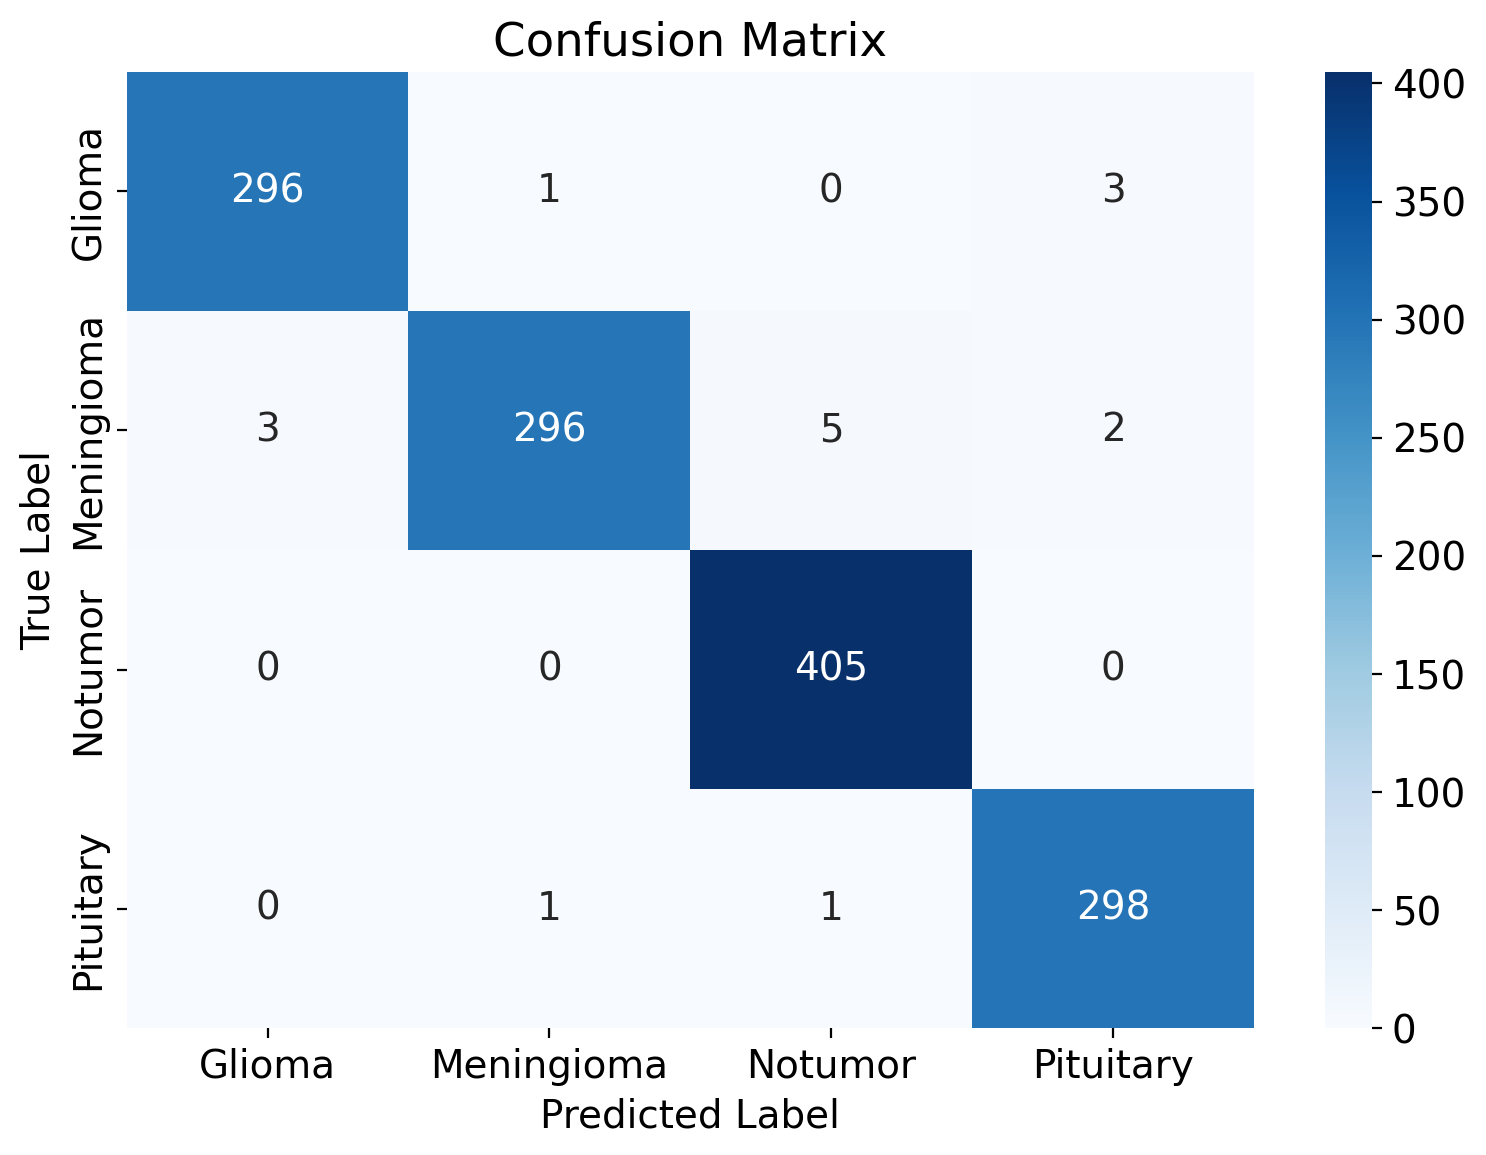

In [67]:
# Predict on test data
y_true = test_generator.classes
y_pred_probs = best_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get class names from generator
class_names = list(test_generator.class_indices.keys())

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot with seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[name.title() for name in class_names],
            yticklabels=[name.title() for name in class_names])

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


##### Best model parameter summary

In [59]:
best_model.summary()

Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_196 (Conv2D)             │ (None, 150, 150, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_147               │ (None, 50, 50, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_197 (Conv2D)             │ (None, 50, 50, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_148               │ (None, 16, 16, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_198 (Conv2D)             │ (None, 16, 16, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_149               │ (None, 5, 5, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_199 (Conv2D)             │ (None, 5, 5, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_49 (Flatten)            │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 256)            │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,150,766 (15.83 MB)

 Trainable params: 1,383,588 (5.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,767,178 (10.56 MB)

##### Visualize Best Model layered view

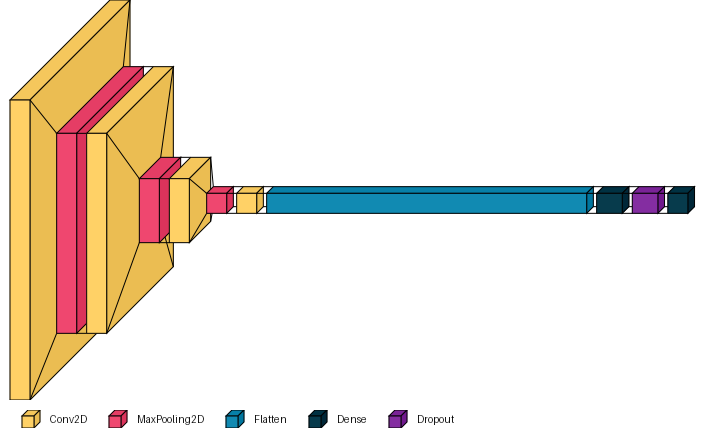

In [63]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from visualkeras import layered_view

# Visualize the model without warnings
layered_view(best_model, legend=True, max_xy=300)


#### Plot sample predictions on best model

In [91]:
categories = list(test_generator.class_indices.keys())

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step 


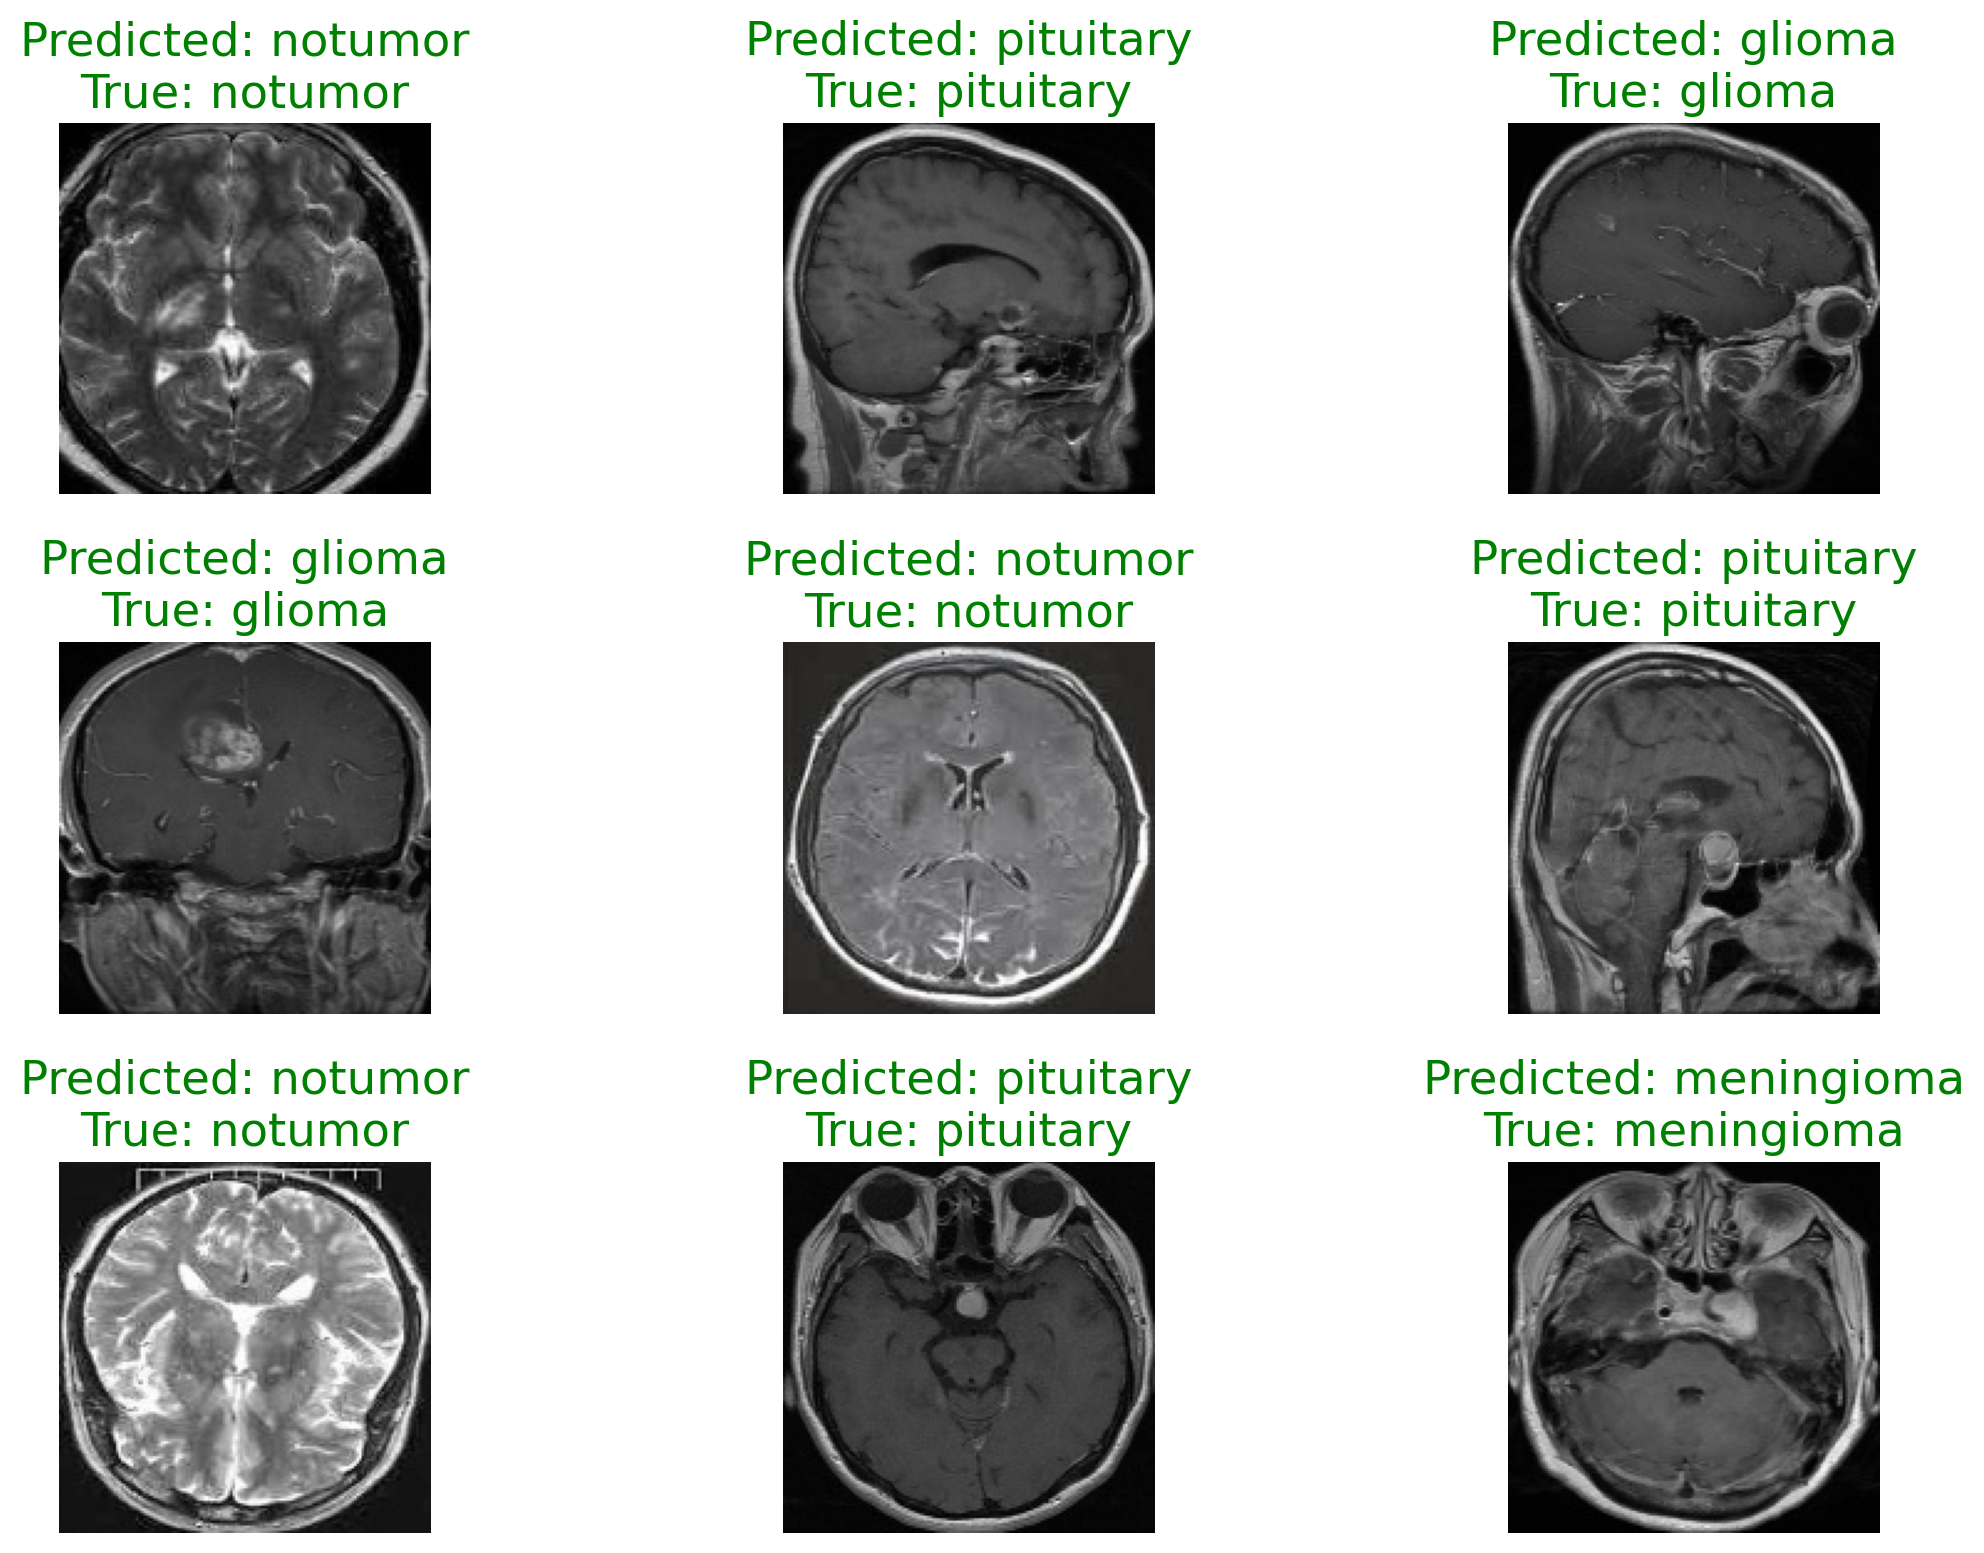

In [92]:
# Plot predictions on sample images
plot_sample_predictions(best_model, test_generator, categories, test_dir)

#### visualizing CNN layers

In [ ]:
# Load and resize image
image = cv2.imread('m.jpg')
resize = cv2.resize(image, (150, 150))
input_image = np.expand_dims(resize, axis=0)

# Visualize the input image
plt.figure(figsize=(4, 4))
plt.imshow(cv2.cvtColor(resize, cv2.COLOR_BGR2RGB))
plt.title("Input Image")
plt.axis('off')
plt.show()

# Loop through different intermediate model depths
for num_layers in range(1, 5): 
    # Create intermediate model
    intermediate_model = Sequential()
    for layer in best_model.layers[:num_layers]:
        intermediate_model.add(layer)

    # Ensure it's built
    intermediate_model.build(input_shape=(None, 150, 150, 3))

    # Get feature maps
    feature_maps = intermediate_model.predict(input_image)

    if feature_maps.ndim == 4:
        num_channels = feature_maps.shape[-1]
        num_rows = int(np.ceil(num_channels / 5))
        num_cols = min(num_channels, 5)

        fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 3 * num_rows))
        fig.suptitle(f"Feature Maps After First {num_layers} Layers", fontsize=18, fontweight='bold')

        ax = np.array(ax).reshape(num_rows, num_cols)

        for idx, (row, col) in enumerate(itertools.product(range(num_rows), range(num_cols))):
            if idx < num_channels:
                fmap = feature_maps[0, :, :, idx]
                # Normalize feature map
                fmap -= fmap.min()
                fmap /= (fmap.max() + 1e-5)
                ax[row, col].imshow(fmap, cmap='viridis')
                ax[row, col].axis('off')
            else:
                ax[row, col].axis('off')

        plt.tight_layout(rect=[0, 0, 1, 0.95])        
        plt.show()
        
    else:
        print(f"Skipping layer[:{num_layers}] — not a 4D output.")

In [62]:
best_model.summary()

Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_196 (Conv2D)             │ (None, 150, 150, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_147               │ (None, 50, 50, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_197 (Conv2D)             │ (None, 50, 50, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_148               │ (None, 16, 16, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_198 (Conv2D)             │ (None, 16, 16, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_149               │ (None, 5, 5, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_199 (Conv2D)             │ (None, 5, 5, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_49 (Flatten)            │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 256)            │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,150,766 (15.83 MB)

 Trainable params: 1,383,588 (5.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,767,178 (10.56 MB)

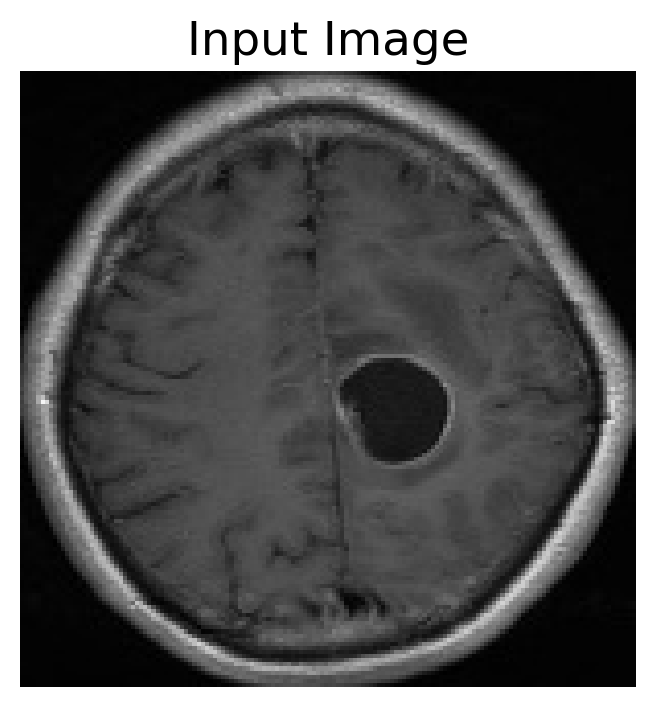

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


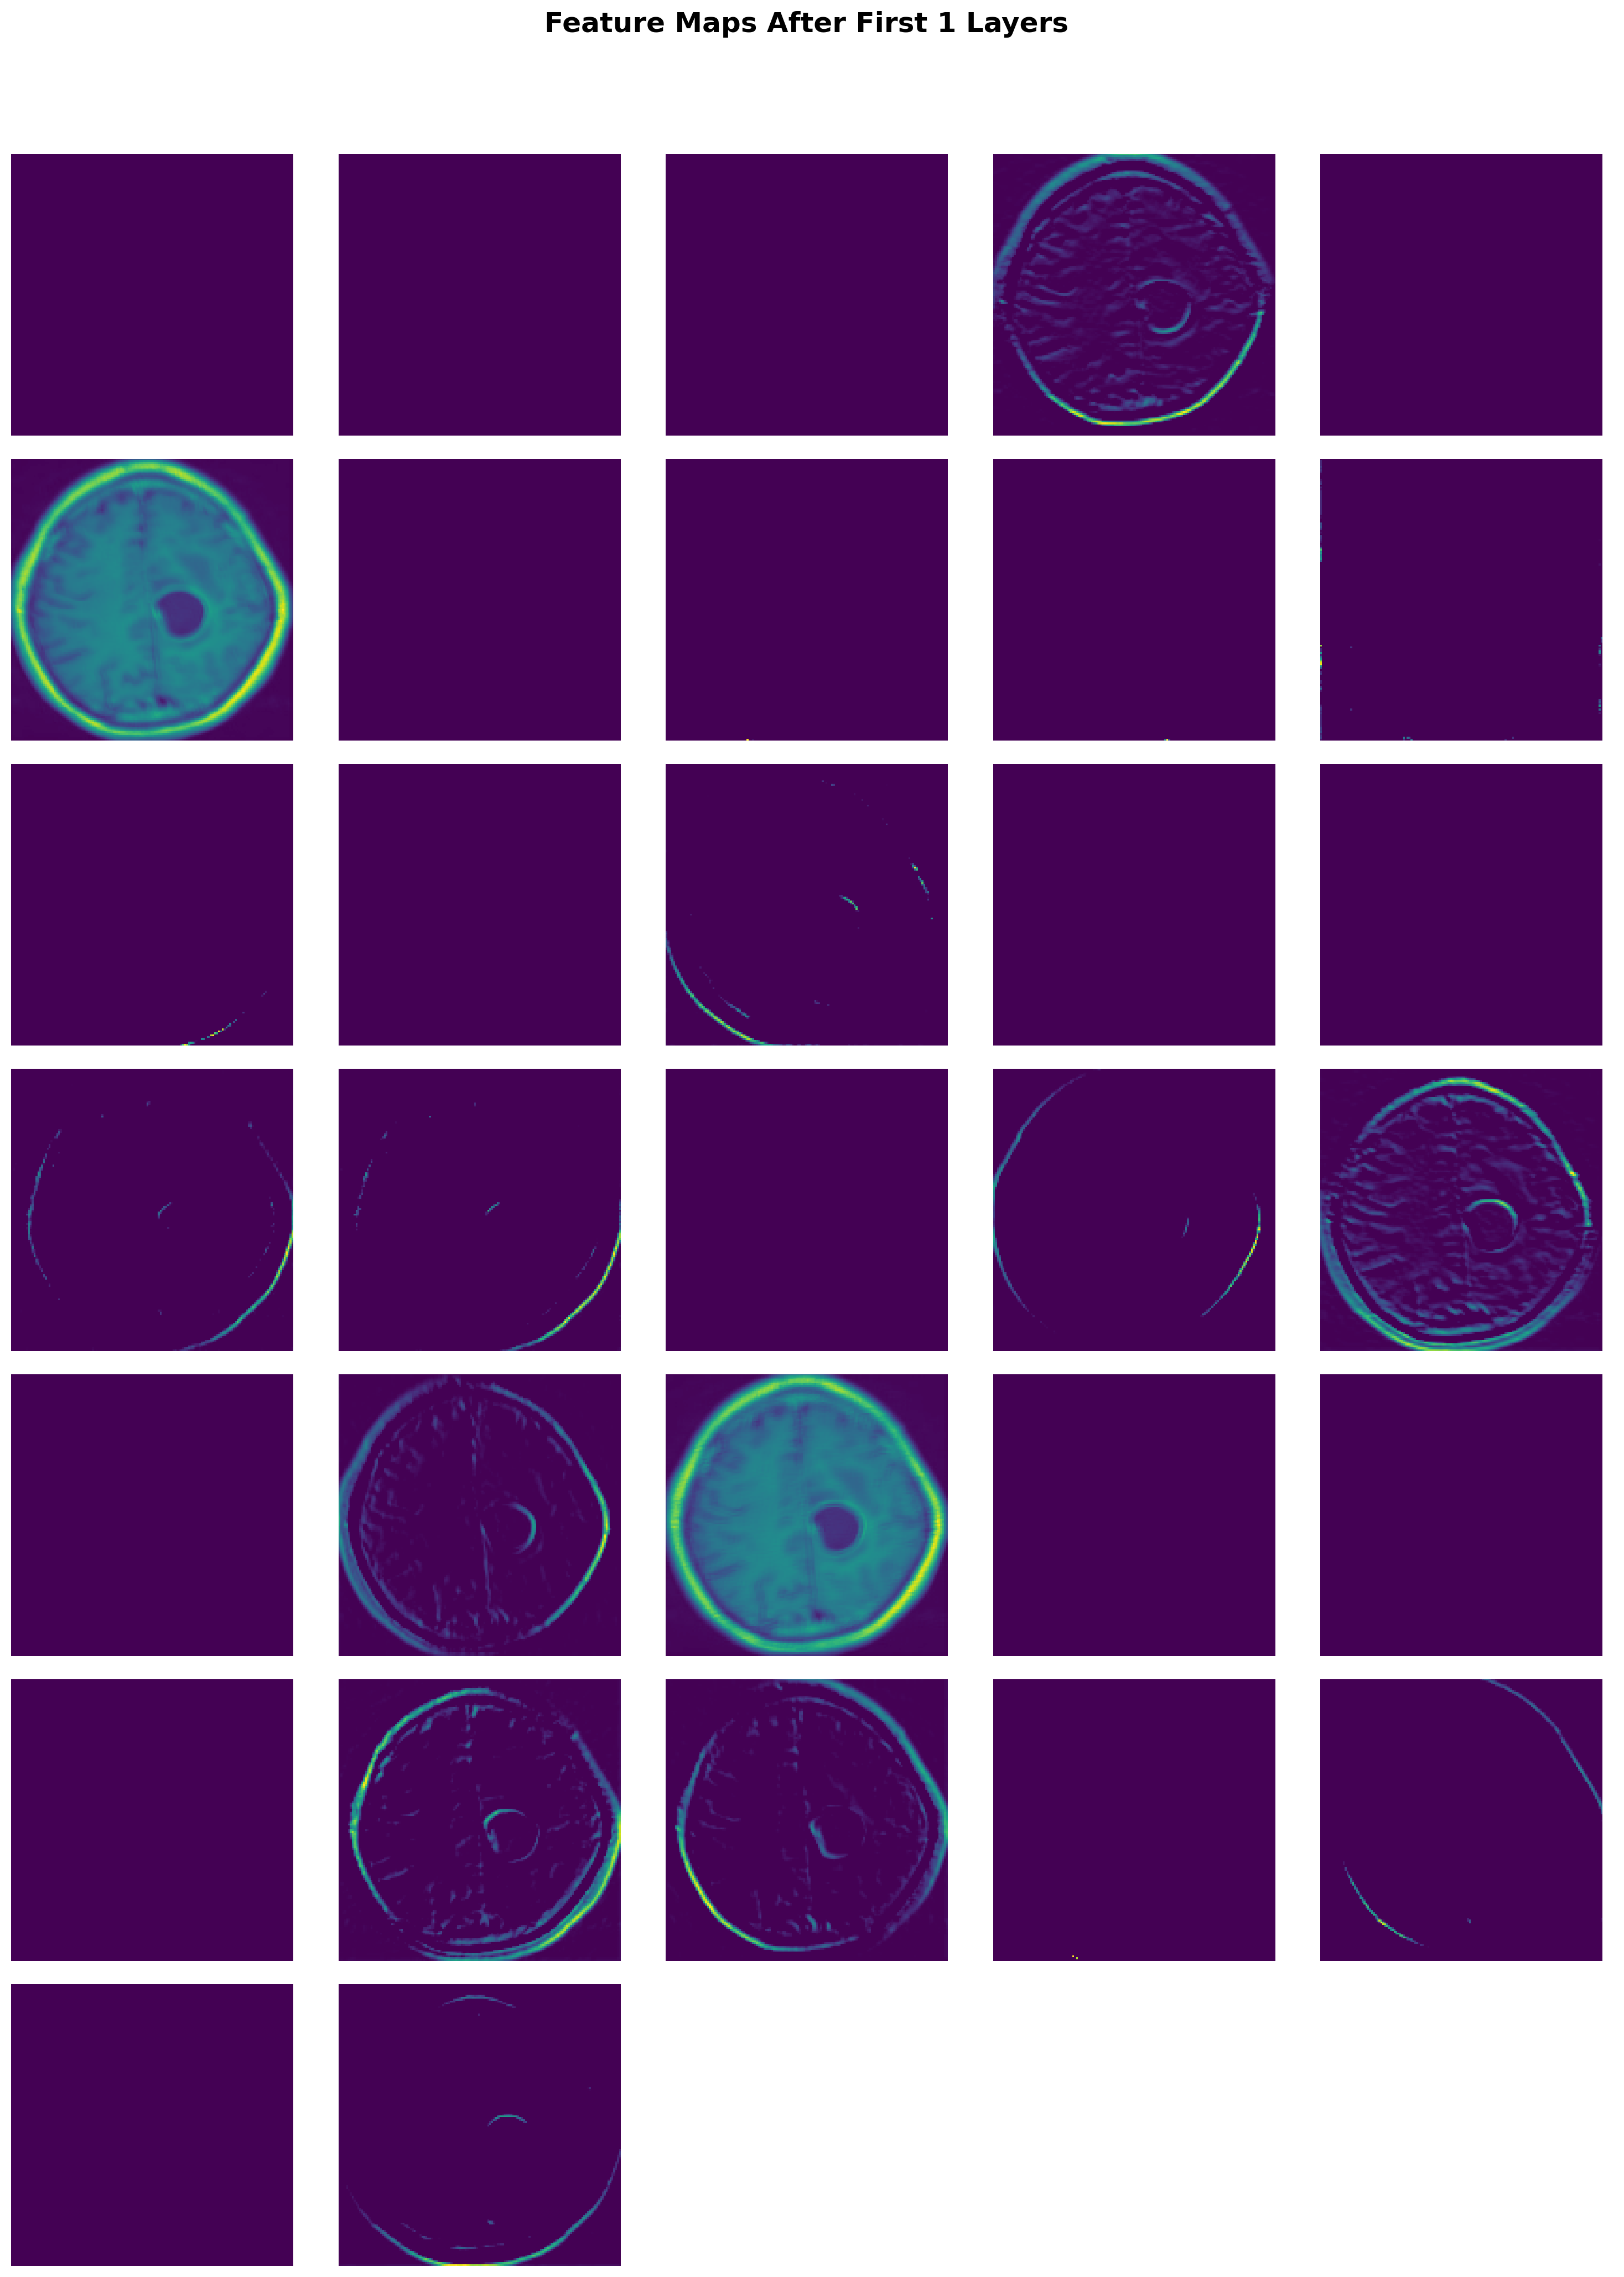

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


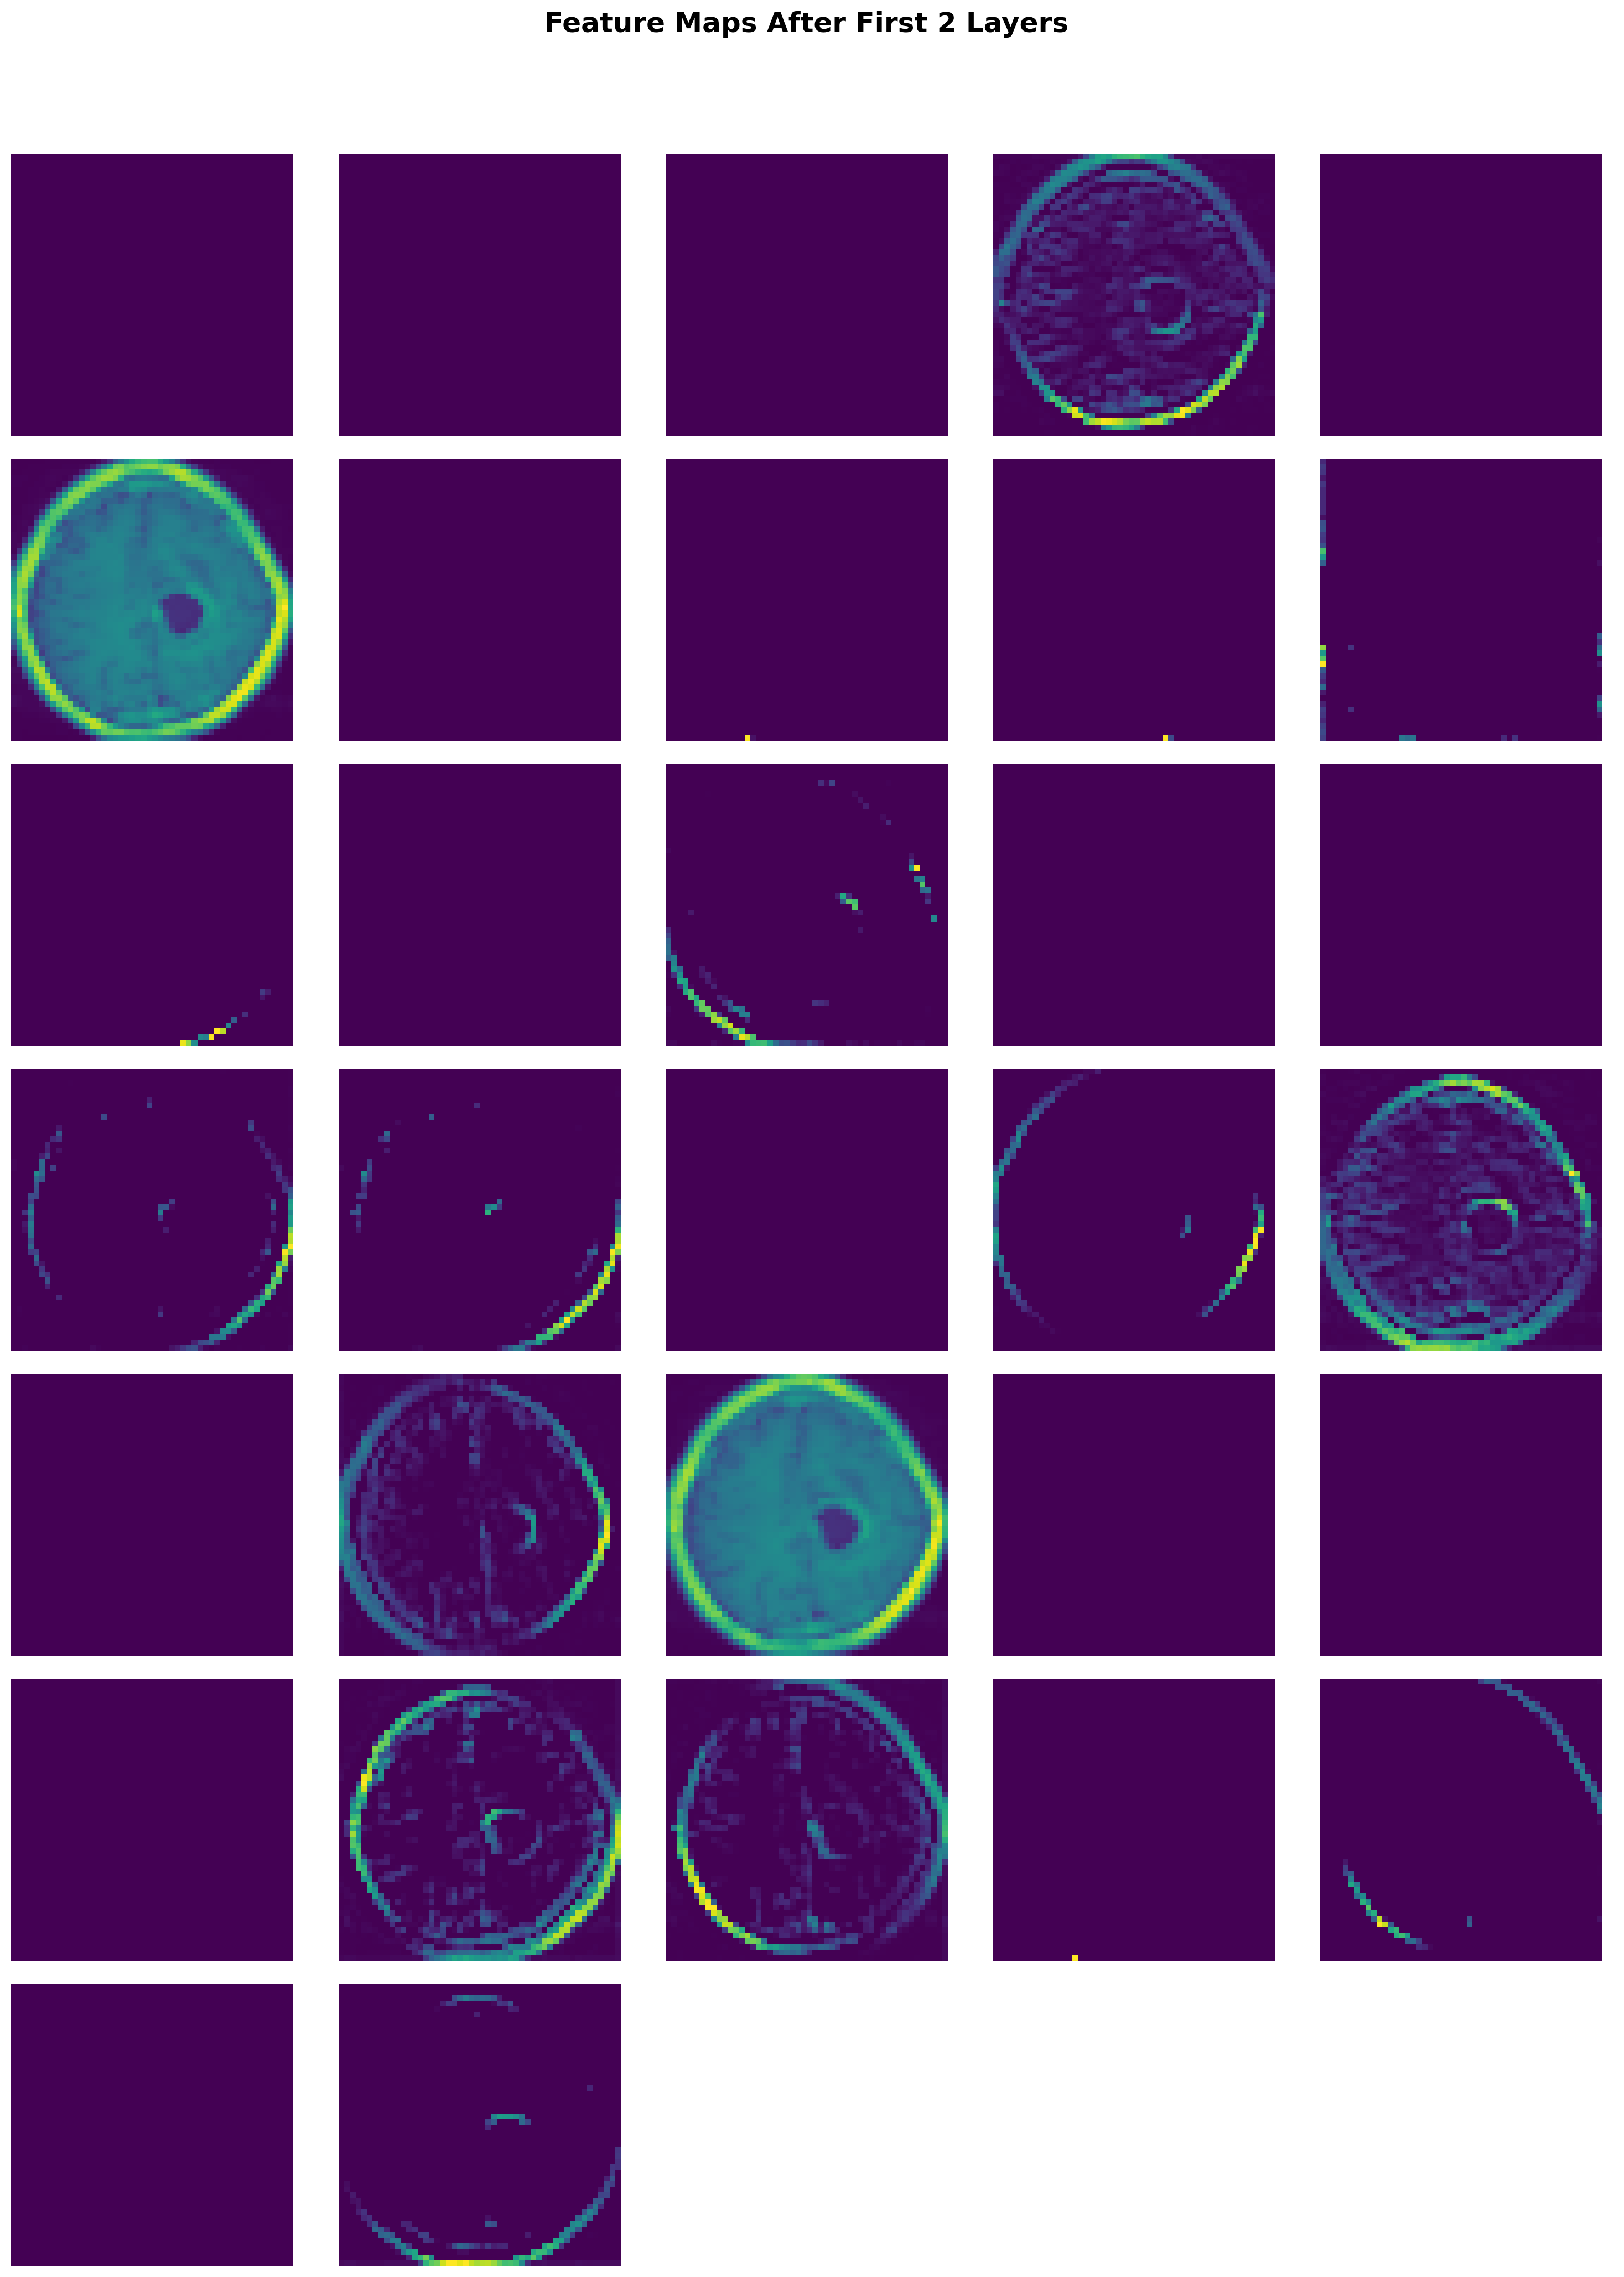

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


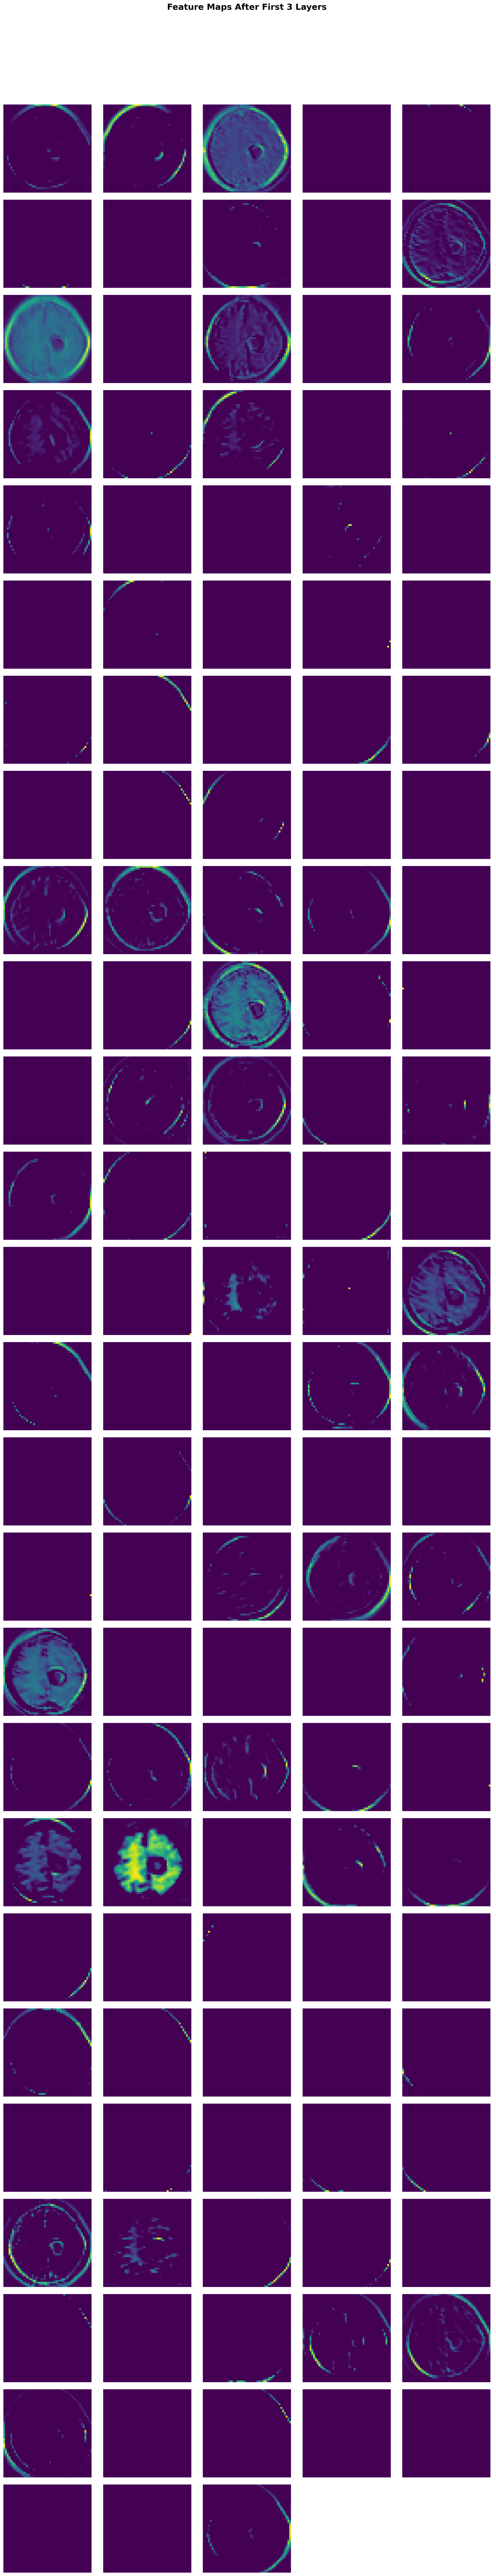

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


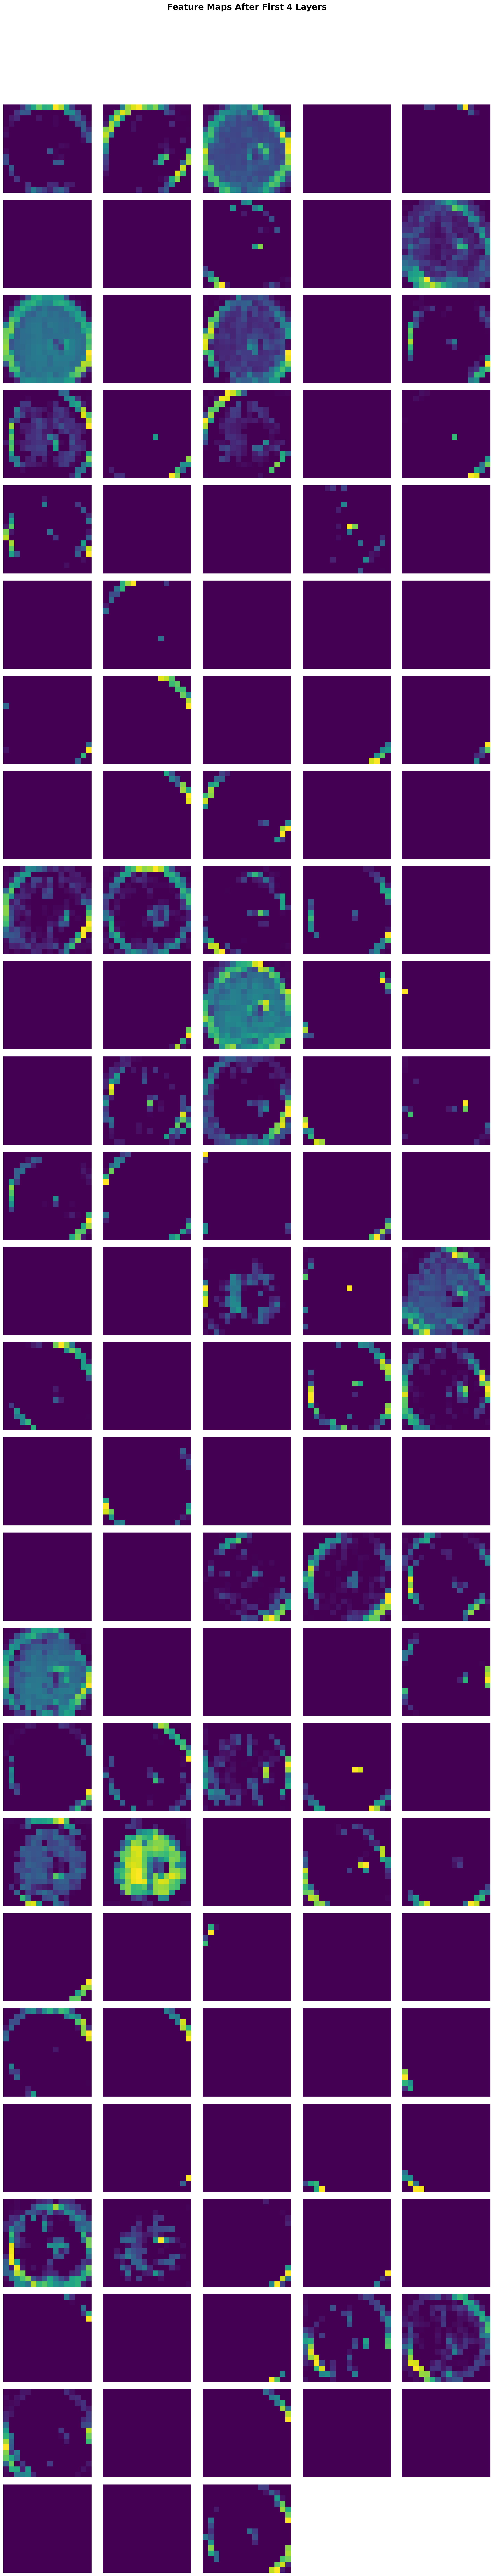

In [89]:
# Load and resize image
image = cv2.imread('Te-gl_0291.jpg')
resize = cv2.resize(image, (150, 150))
input_image = np.expand_dims(resize, axis=0)

# Visualize the input image
plt.figure(figsize=(4, 4))
plt.imshow(cv2.cvtColor(resize, cv2.COLOR_BGR2RGB))
plt.title("Input Image")
plt.axis('off')
plt.show()

# Loop through different intermediate model depths
for num_layers in range(1, 5): 
    # Create intermediate model
    intermediate_model = Sequential()
    for layer in best_model.layers[:num_layers]:
        intermediate_model.add(layer)

    # Ensure it's built
    intermediate_model.build(input_shape=(None, 150, 150, 3))

    # Get feature maps
    feature_maps = intermediate_model.predict(input_image)

    if feature_maps.ndim == 4:
        num_channels = feature_maps.shape[-1]
        num_rows = int(np.ceil(num_channels / 5))
        num_cols = min(num_channels, 5)

        fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 3 * num_rows))
        fig.suptitle(f"Feature Maps After First {num_layers} Layers", fontsize=18, fontweight='bold')

        ax = np.array(ax).reshape(num_rows, num_cols)

        for idx, (row, col) in enumerate(itertools.product(range(num_rows), range(num_cols))):
            if idx < num_channels:
                fmap = feature_maps[0, :, :, idx]
                # Normalize feature map
                fmap -= fmap.min()
                fmap /= (fmap.max() + 1e-5)
                ax[row, col].imshow(fmap, cmap='viridis')
                ax[row, col].axis('off')
            else:
                ax[row, col].axis('off')

        plt.tight_layout(rect=[0, 0, 1, 0.95])        
        plt.show()
        
    else:
        print(f"Skipping layer[:{num_layers}] — not a 4D output.")